# Single-band deblending using wavelets

This notebook uses a modified version of the postive starlet algorithm in Starck et al. 2011 to perform single band deblending.

In [2]:
# Import Packages and setup
import os
import logging
logger = logging.getLogger('scarlet')
logger.setLevel(logging.DEBUG)
logger = logging.getLogger("proxmin")
logger.setLevel(logging.DEBUG)

import numpy as np
import scarlet
from scarlet.detect import bounds_to_bbox
from scarlet.detect_pybind11 import get_footprints
import scarlet.display
from scarlet.display import AsinhMapping
from scarlet.interpolation import get_filter_coords, get_filter_bounds
from scarlet.operator import prox_monotonic_mask
from scarlet.operators_pybind11 import get_valid_monotonic_pixels, linear_interpolate_invalid_pixels
from scarlet.wavelet import starlet_transform, get_multiresolution_support

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno', interpolation='none', origin="lower")

loading data from'/Users/fred3m/data/hsc_deep/blend_10.npz'


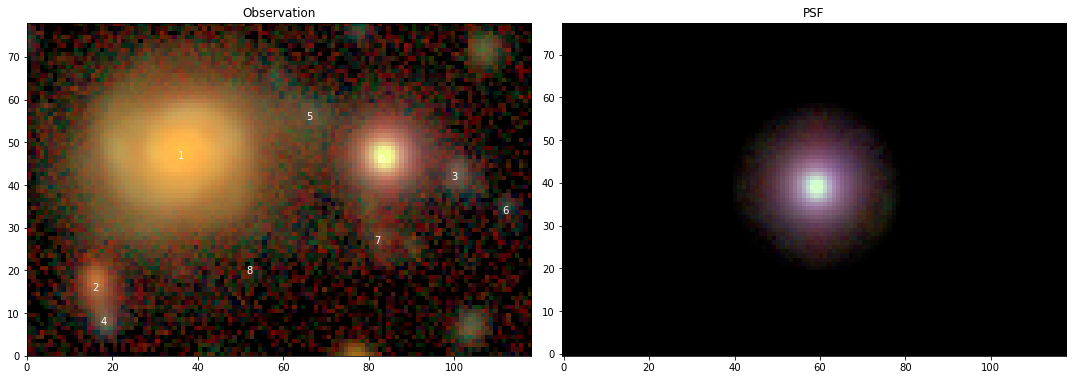

In [3]:
# Load the exposure data
filters = "grizy"
idx = 10
datapath = "/Users/fred3m/data/hsc_deep"
filename = "blend_{0}.npz".format(idx)
print("loading data from'{0}'".format(os.path.join(datapath, filename)))
data = np.load(os.path.join(datapath, filename))
images = data["image"]
mask = data["mask"]
variance = data["variance"]
weights = 1/variance
psf = scarlet.ImagePSF(data["psf"])
centers = data["peaks"]

# Initialize the scarlet model
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters))
model_frame = scarlet.Frame(
    images.shape,
    psf=model_psf,
    channels=filters)
# Initialize the observation
observation = scarlet.Observation(
    images,
    psf=psf,
    weights=weights,
    channels=filters).match(model_frame)
# Display the observation
stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
scarlet.display.show_observation(observation, norm=norm, sky_coords=centers, show_psf=True, figsize=(15,9))
plt.show()

# Create the wavelet coefficients in each band

We could use the `scarlet.get_wavelets` method from scarlet but for demonstration purposes we want to display both the raw coefficients and the detection coefficients that have been filtered in order to only use "significant" pixels as defined in Starck et al. 2011.

In [4]:
%%time
sigma = np.median(np.sqrt(variance), axis=(1,2))

coeffs = []
raw_coeffs = []
for b, image in enumerate(images):
    _coeffs = starlet_transform(image, scales=3)
    M = get_multiresolution_support(image, _coeffs, sigma[b], K=3, epsilon=1e-1, max_iter=20)
    
    coeffs.append(M * _coeffs)
    raw_coeffs.append(_coeffs)
coeffs = np.array(coeffs)
raw_coeffs = np.array(raw_coeffs)

CPU times: user 24.7 ms, sys: 2.22 ms, total: 26.9 ms
Wall time: 25.9 ms


# Detect peaks

While it is possible to detect peaks at each wavelet scale, testing has revealed that the first scale is too noisy (as it is unconvolved and noise fluxuations cause false peak detections) and at the resolution of HSC scales higher than the 2nd scale do not add any new peaks for the vast majority of blends. So for this example we only use detections from the 2nd wavelet scale.

In [5]:
detect = np.sum(coeffs, axis=0)
%time footprints = get_footprints(detect[1], min_separation=0, min_area=4, thresh=0)
peaks = []
for fp in footprints:
    peaks += fp.peaks
print(f"\ndetected {len(peaks)} peaks")

CPU times: user 327 µs, sys: 29 µs, total: 356 µs
Wall time: 347 µs

detected 25 peaks


## Display the results

We display the original image and the image reconstructed from the wavelet coefficients, followed by the detection coefficients at each scale with the 2nd scale detections marked on all of them.

2.1869621775749692e-06


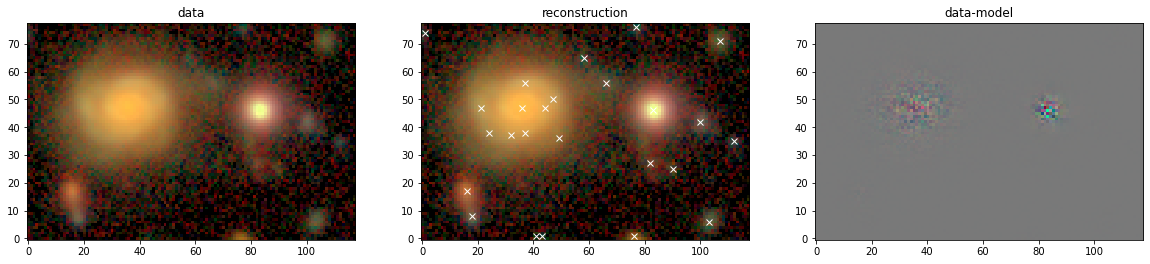

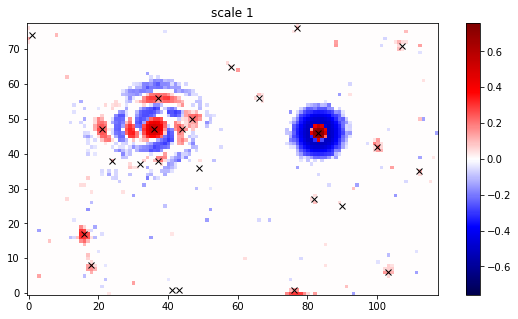

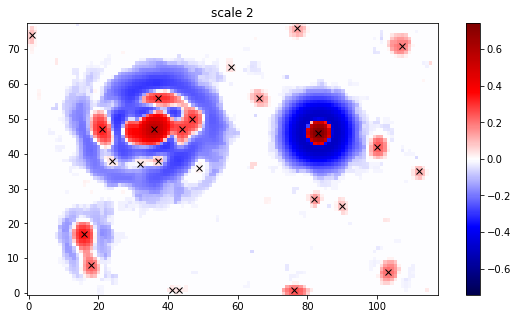

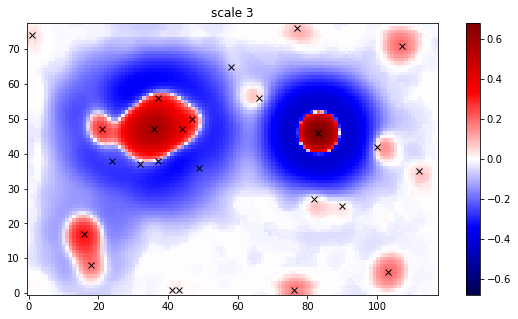

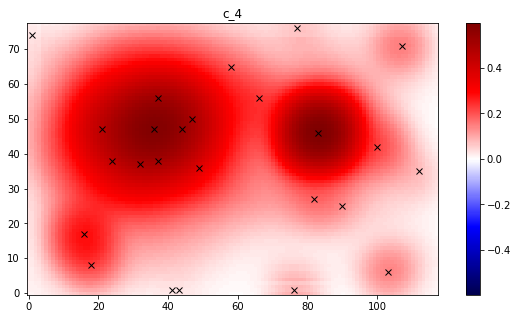

In [6]:
from scarlet.wavelet import starlet_transform, get_multiresolution_support, starlet_reconstruction

sigma = np.median(np.sqrt(variance), axis=(1,2))
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
fig = plt.figure(figsize=(20,10))
ax = [fig.add_subplot(1,3,1+n) for n in range(3)]

img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
ax[0].imshow(img_rgb, origin="lower")
ax[0].set_title("data")

_images = np.array([starlet_reconstruction(c) for c in raw_coeffs])
_rgb = scarlet.display.img_to_rgb(_images, norm=norm)
ax[1].imshow(_rgb, origin="lower")
ax[1].set_title("reconstruction")

for peak in peaks:
    ax[1].plot(peak.x, peak.y, "wx")

residual = images - _images
print(np.max(residual))
_rgb = scarlet.display.img_to_rgb(residual)
ax[2].imshow(_rgb, origin="lower")
ax[2].set_title("data-model")
plt.show()


for scale, a in enumerate(detect):
    im = np.arcsinh(10*a)/10
    vmax = np.max(np.abs(im))
    plt.figure(figsize=(10,5))
    plt.imshow(im, origin="lower", vmin=-vmax, vmax=vmax, cmap="seismic")
    for peak in peaks:
        plt.plot(peak.x, peak.y, "kx")
    if scale < 3:
        plt.title(f"scale {scale+1}")
    else:
        plt.title(f"c_{scale+1}")
    plt.colorbar()
    plt.show()

# Deblend the image

## Classes and functions needed for single band deblending

We use some classes and methods not included in scarlet in order to perform a custom optimization using an algorithm similar to the positive starlet algorithm introduced in Starck et al. 2011

In [50]:
class MonotonicStructure:
    """A single scale monotonic structure
    
    Starck et al. 2011 defines a `Structure` as a single scale
    connected footprint. We expand that definition here to
    require each stucture to monotonically decrease from the
    center along any (potentially curved) direction.
    """
    def __init__(self, model, bbox, peak, scale, peak_search_radius):
        self.model = model
        self.bbox = bbox
        self.peak = peak
        self.scale = scale
        self.peak_radius = peak_search_radius
        self.z = model.copy()
        self.t = 1

    @staticmethod
    def from_wavelets(wavelets, peak, scale, peak_search_radius):
        """Create the structure from a collection of starlet coefficients
        """
        _, model, bounds = prox_monotonic_mask(wavelets, 0, peak, peak_search_radius, max_iter=20)
        bbox = bounds_to_bbox(bounds)
        return MonotonicStructure(model[bbox.slices], bbox, peak, scale, peak_search_radius)

    def update(self, grad):
        """Update the internal model from a gradient.
        
        Note that this model receives the gradient update for
        the entire image and the prox_monotonic_mask returns
        the bounds needed to extract only the relevant pixels
        from the full gradient, allowing the box size to
        change in each iteration.
        """
        # backup the unmodified gradient
        grad = grad.copy()
        oldSlices = self.bbox.slices
        backup_grad = grad[oldSlices].copy()
        grad[self.bbox.slices] += self.model

        # Set the new bounding box and model
        _, model, bounds = prox_monotonic_mask(grad, 0, self.peak, self.peak_radius, max_iter=10)
        self.bbox = bounds_to_bbox(bounds)
        self.model = model[self.bbox.slices]

        # restore the gradient
        grad[oldSlices] = backup_grad


class MonotonicObject:
    """A multi-scale collection of MonotonicStructures
    
    Using the terminology from Starck et al. 2011,
    an `Object` is a collection of structures across
    multiple scales. We extend that definition to make
    a `MonotonicObject` a collection of monotonic structures.
    """
    def __init__(self, structures, peak, peak_search_radius):
        self.structures = structures
        self.peak = peak
        self.peak_search_radius = peak_search_radius

    @property
    def bbox(self):
        """Combination of the boxes across scales
        """
        bbox = self.structures[0].bbox
        for struct in self.structures:
            bbox &= struct.bbox
        return bbox

    def image(self, shape):
        """The image reconstructed from the wavelet model at each scale
        """
        bbox = self.bbox
        model = np.zeros((len(self.structures),) + shape)
        for scale, struct in enumerate(self.structures):
            if struct.model.size > 0:
                model[(scale,) + struct.bbox.slices] = struct.model
        return starlet_reconstruction(model)

    def update(self, grad):
        """Update each of the substructures
        """
        for scale, structure in enumerate(self.structures):
            structure.update(grad[scale])


def get_model(objects, shape):
    """Generate the full model for a collection of objects
    """
    model = np.zeros(shape)
    for obj in objects:
        for scale, struct in enumerate(obj.structures):
            # assert np.min(struct.model) >= 0
            model[(scale,) + struct.bbox.slices] += struct.model
    return model


def get_z_model(objects, shape):
    """Generate the model at each scale for a collection of objects
    """
    model = np.zeros(shape)
    for obj in objects:
        for scale, struct in enumerate(obj.structures):
            # assert np.min(struct.model) >= 0
            model[(scale,) + struct.bbox.slices] += struct.z
    return model


def convolve_model(model, filters):
    """Convolve the model with a filter used to ensure that
    the coefficents are band limited in each scale
    """
    from scarlet.operators_pybind11 import apply_filter

    result = np.empty(model.shape, dtype=model.dtype)
    # No need to convolve the first two scales
    result[0] = model[0]

    for scale in range(1, len(model)):
        phi, bounds = filters[scale]
        apply_filter(
            model[scale],
            phi[0].reshape(-1),
            bounds[0][0],
            bounds[0][1],
            bounds[0][2],
            bounds[0][3],
            result[scale],
        )

        apply_filter(
            result[scale].copy(),
            phi[1].reshape(-1),
            bounds[1][0],
            bounds[1][1],
            bounds[1][2],
            bounds[1][3],
            result[scale],
        )

    return result


def peaks_to_objects(peaks, wavelets, peak_search_radius):
    """Create a multi-scale object for each detected peak
    """
    structures = {}

    for scale, _wavelets in enumerate(wavelets):
        for peak in peaks:
            structure = MonotonicStructure.from_wavelets(_wavelets, peak, scale, peak_search_radius)
            peak = tuple(peak)
            if peak not in structures.keys():
                structures[peak] = []
            structures[peak].append(structure)

    objects = []
    for peak, structures in structures.items():
        obj = MonotonicObject(structures, peak, peak_search_radius)
        objects.append(obj)
    return objects


def wavelet_deblend(wavelets, objects, max_iter=100, stepsize=0.2):
    """Deblend a single band image using wavelets
    """
    M = wavelets != 0

    filters = {}

    # Create the filters to make the coefficients band limited
    for scale in range(1, len(wavelets)):
        x1 = 2 ** scale
        x2 = 2 ** (scale + 1)
        x = np.linspace(-(x2 - 1), x2 - 1, 2 * x2 - 1)
        y = (np.abs(x - x2) ** 3 - 4 * np.abs(x - x1) ** 3 + +6 * np.abs(x) ** 3 - 4 * np.abs(x + x1) ** 3 + np.abs(
            x + x2) ** 3) / 12
        phi = y / np.sum(y)
        phi_x = phi[None, :]
        phi_y = phi_x.T
        coords = get_filter_coords(phi_x)
        bounds_x = get_filter_bounds(coords.reshape(-1, 2))
        coords = get_filter_coords(phi_y)
        bounds_y = get_filter_bounds(coords.reshape(-1, 2))
        filters[scale] = ((phi_y, phi_x), (bounds_y, bounds_x))

    # Initialize the model
    model = get_model(objects, wavelets.shape)

    for it in range(max_iter):
        _image = starlet_reconstruction(model)
        _starlets = starlet_transform(_image, scales=len(model) - 1)
        residual = M * (wavelets - _starlets)
        residual = convolve_model(residual, filters)

        for obj in objects:
            obj.update(residual*stepsize)

        model = get_model(objects, wavelets.shape)
        model = convolve_model(model, filters)
    model = get_model(objects, wavelets.shape)
    model = convolve_model(model, filters)
    return model

## Deblend the objects in each band independently

In [53]:
full_model = []
all_objects = []
all_wavelets = []
centers = [(peak.y, peak.x) for peak in peaks]

for _coeffs in raw_coeffs:
    objects = peaks_to_objects(centers, _coeffs, peak_search_radius=2)
    %time model = wavelet_deblend(_coeffs, objects, max_iter=500)
    all_wavelets.append(model)
    all_objects.append(objects)
    full_model.append(starlet_reconstruction(model))
full_model = np.array(full_model)

CPU times: user 27.9 s, sys: 78.1 ms, total: 28 s
Wall time: 28 s
CPU times: user 28.8 s, sys: 104 ms, total: 28.9 s
Wall time: 28.9 s
CPU times: user 31.3 s, sys: 88.9 ms, total: 31.4 s
Wall time: 31.4 s
CPU times: user 29.3 s, sys: 82.3 ms, total: 29.4 s
Wall time: 29.4 s
CPU times: user 29.6 s, sys: 71.4 ms, total: 29.6 s
Wall time: 29.7 s


# Display the results

## Display the full model and residual

In this section we display the data, model, and residual, followed by the full model at each scale.

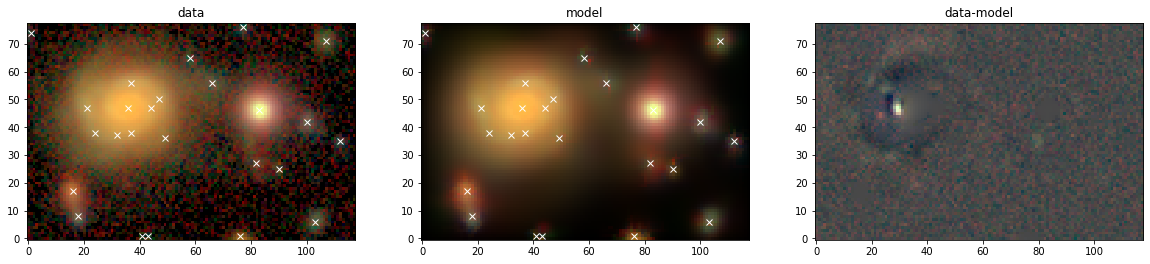

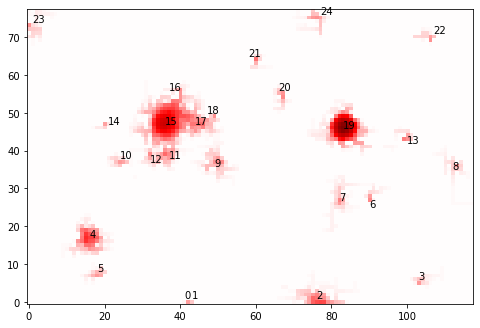

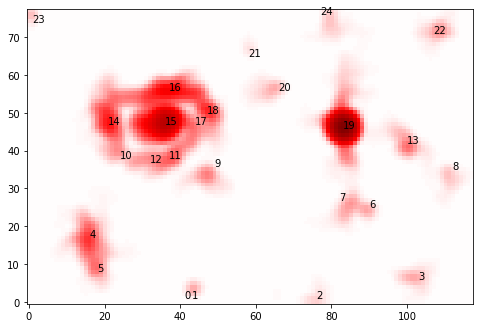

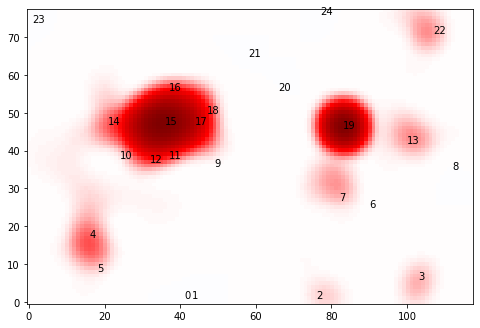

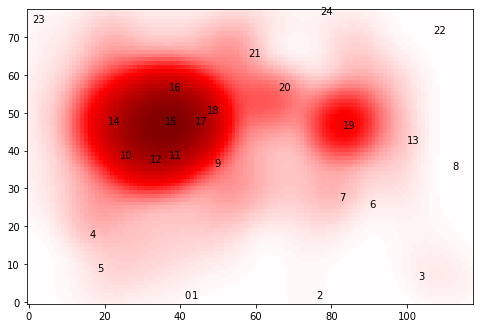

In [75]:
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
fig = plt.figure(figsize=(20,10))
ax = [fig.add_subplot(1,3,1+n) for n in range(3)]

rgb = scarlet.display.img_to_rgb(images, norm=norm)
ax[0].imshow(rgb, origin="lower")
ax[0].set_title("data")
for obj in objects:
    peak = obj.peak
    ax[0].plot(peak[1], peak[0], "wx")

rgb = scarlet.display.img_to_rgb(full_model, norm=norm)
ax[1].imshow(rgb, origin="lower")
ax[1].set_title("model")
for obj in objects:
    peak = obj.peak
    ax[1].plot(peak[1], peak[0], "wx")

residual = images - full_model
rgb = scarlet.display.img_to_rgb(residual)
ax[2].imshow(rgb, origin="lower")
ax[2].set_title("data-model")
plt.show()

model = all_wavelets[-1]
for a in model:
    im = np.arcsinh(10*a)/10
    vmax = np.max(np.abs(im))
    plt.figure(figsize=(8,8))
    plt.imshow(im, origin="lower", vmin=-vmax, vmax=vmax, cmap="seismic")
    for k, obj in enumerate(objects):
        center = obj.peak
        plt.text(center[1], center[0], str(k), color="k")
    #plt.colorbar()
    plt.show()

## Display select sources

Many of the peaks are pieces of the spiral galaxy on the left. To avoid displaying too many sources we show enough of the remaining sources to show where the deblender succeeds and fails, including peak 15, which is the central component of the large spiral galaxy with the spiral arms removed.

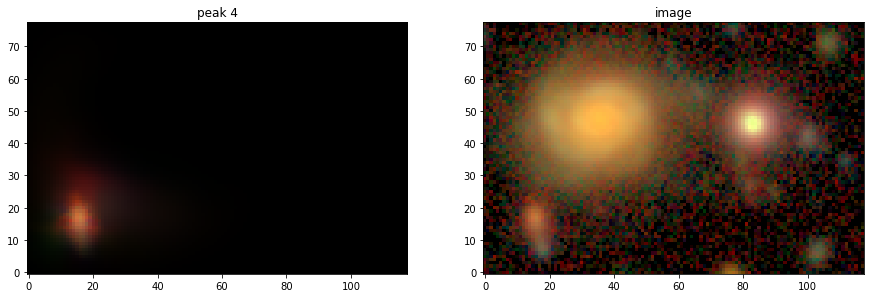

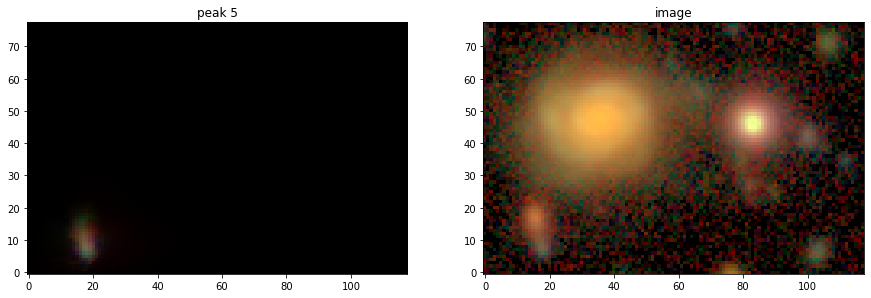

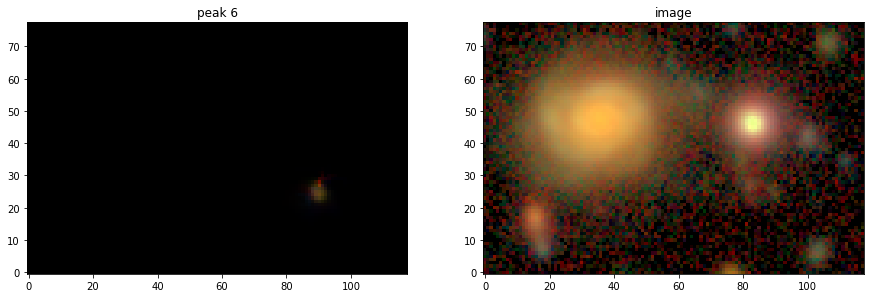

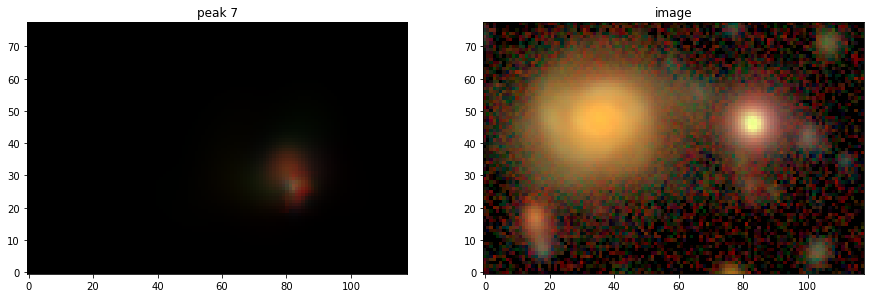

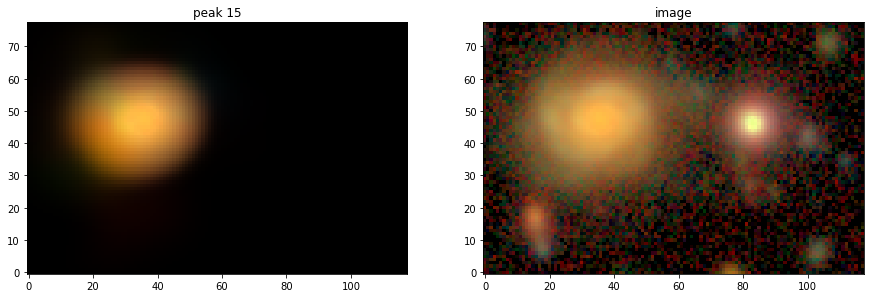

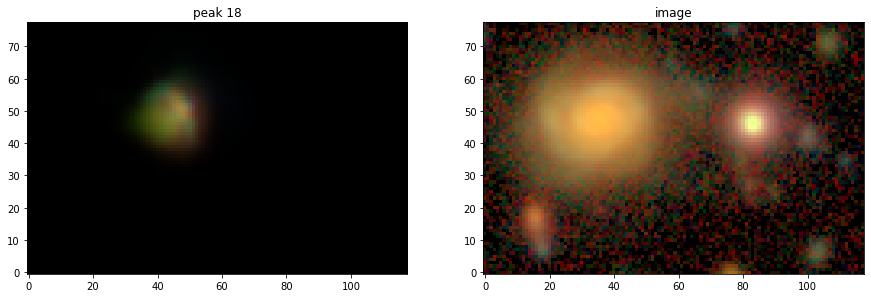

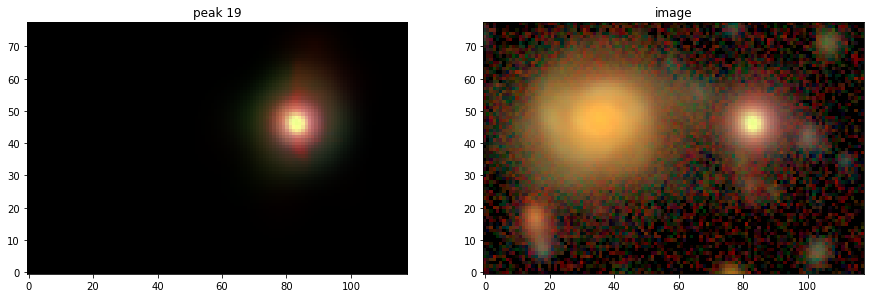

In [74]:
show_sources = [4, 5, 6, 7, 15, 18, 19]

for idx in show_sources:
    model = np.zeros(images.shape)
    for band in range(images.shape[0]):
        src = all_objects[band][idx]
        model[band] += src.image(model.shape[1:])
    rgb = scarlet.display.img_to_rgb(model, norm=norm)
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(rgb)
    plt.title(f"peak {idx}")
    plt.subplot(122)
    plt.imshow(img_rgb)
    plt.title("image")
    plt.show()